Pipeline illustration
====
Starting from a masked image, show all the steps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Read in and display an image + mask

"""
import pathlib
import numpy as np
import matplotlib.pyplot as plt

img_index = "0200"

data_dir = "data/"
image_path = pathlib.Path(data_dir) / "original cut" / f"{img_index}.tif"
mask_path = pathlib.Path(data_dir) / "masks cut" / f"{img_index}.tif"

# Check that they exist
assert image_path.exists(), image_path
assert mask_path.exists(), mask_path

raw_image = plt.imread(image_path)
raw_mask = plt.imread(mask_path)

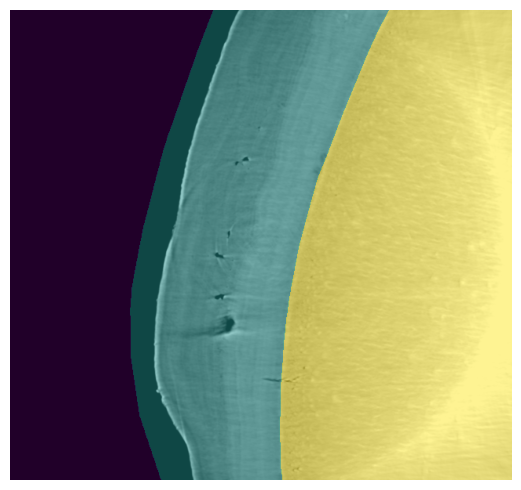

In [3]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5))

axis.imshow(raw_image, cmap="gray")
axis.imshow(raw_mask, alpha=0.5)

axis.set_axis_off()

fig.tight_layout()

Straightening
----
First we want to straighten this image so the cementum layers run up/down the image.

We'll do this by finding a set of affine transformations that map points in the curved image above onto a straightened image...

In [4]:
"""
Straighten the image and mask

This works by building two meshes of points: one that curves to follow the mask, and one that is straight
We then find affine transformations that map the straight mesh to the curved mesh, and apply them to the image and mask

see straighten_mesh.ipynb for more details

"""
from cementum import straighten  # This is my library of helper functions
import timeit

# We need to choose how many points we have on the left/inside/right of the mask
n_y = 50  # How many points we have on the y-axis
n_x = 5, 5, 5  # How many points we have to the left/inside/right of the mask

start_time = timeit.default_timer()
curve_pts = straighten.mask_mesh(raw_mask, n_y, n_x)
straight_pts = straighten.straight_mesh(raw_mask, n_y, n_x)
elapsed = timeit.default_timer() - start_time

print(f"Creating meshes: {elapsed:.2f} seconds")

Creating meshes: 0.02 seconds


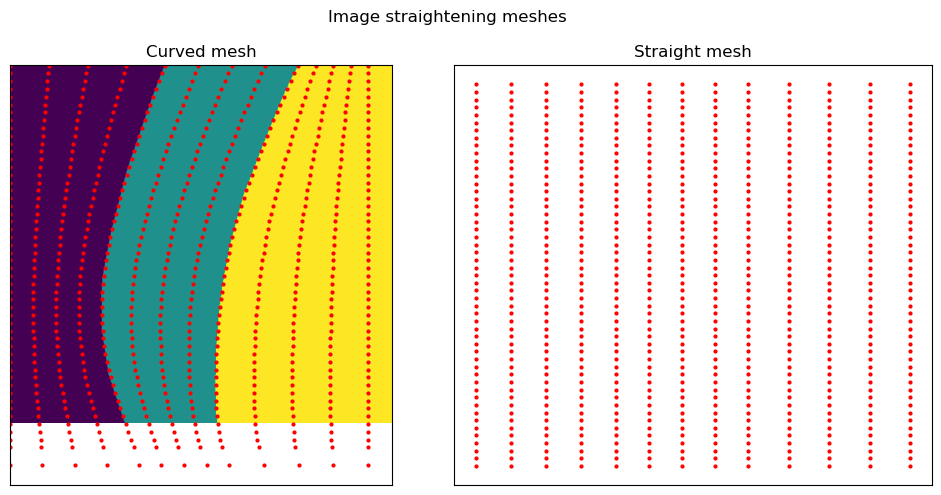

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_kw = {"marker": "o", "linestyle": "none", "markersize": 2, "color": "r"}

axes[0].imshow(raw_mask)
axes[0].plot(curve_pts[:, 0], curve_pts[:, 1], **plot_kw)

axes[1].plot(straight_pts[:, 0], straight_pts[:, 1], **plot_kw)

for axis in axes:
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_title("Curved mesh")
axes[1].set_title("Straight mesh")

fig.suptitle("Image straightening meshes")
fig.tight_layout()

In [6]:
"""
Use these meshes to bend the image into something straight

"""
start_time = timeit.default_timer()
straight_image = straighten.apply_transformation(
    raw_image, curve_pts, straight_pts, order=0
)
img_elapsed = timeit.default_timer() - start_time

print(f"Img straightening: {img_elapsed:.2f} seconds")

Img straightening: 2.04 seconds


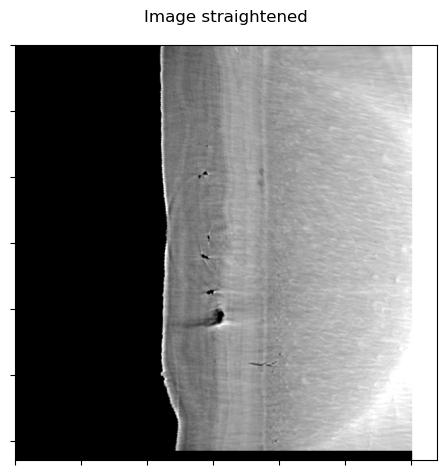

In [7]:
fig, axis = plt.subplots()

axis.imshow(straight_image, cmap="gray")
axis.set_xticklabels([])
axis.set_yticklabels([])

fig.suptitle("Image straightened")
fig.tight_layout()

Some more image processing...
----
For some reason this image straightening has now left us with white pixels along the right edge and black pixel along the bottom. Let's just remove them by hand for now, but it would probably be worth figuring out why this happens...

In [8]:
# Remove white columns
straight_image, _ = straighten.remove_white_cols(straight_image, straight_image)


# Remove black rows
straight_image = straighten.remove_padding(straight_image)

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 29 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 13 zero rows from bottom
  warnings.warn(


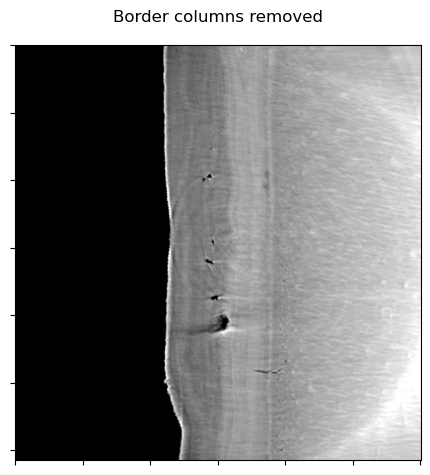

In [9]:
fig, axis = plt.subplots()
axis.imshow(straight_image, cmap="gray")

axis.set_xticklabels([])
axis.set_yticklabels([])

fig.suptitle("Border columns removed")
fig.tight_layout()

Isolating the cementum
----
We now want to isolate the cementum from this straightened image.

The background is clearly distinguishable from the start of the cementum, since there should be a step-change in the pixel intensity.

The dentin is a little harder, since the pixels are about the same brightness as in the cementum region.
We hypothesise that:
 - there is a linear increase average pixel intensity across the image (because of beam hardening?)
 - there is a small bump in intensity at the cementum-dentin boundary, due to the dense intermediate layer between the cementum and dentin.

We'll try to find the location of this bump by fitting to the average intensity of each column, using a sliding window across the image. We'll fit both a straight line, and a straight line with a bump on it, and measure the difference in fit $\chi^2$: we expect to see a sudden step in the $\chi^2$ difference when the bump is encountered, since the straight line function will no longer fit but the straight-line-with-bump will.

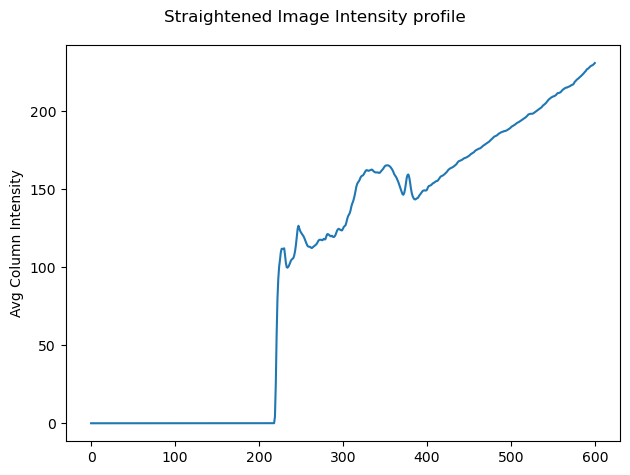

In [11]:
"""
Find the average intensity of the image along the y-axis

"""
fig, axis = plt.subplots()

avg_intensity = np.mean(straight_image, axis=0)

axis.plot(avg_intensity)

axis.set_ylabel("Avg Column Intensity")

fig.suptitle("Straightened Image Intensity profile")
fig.tight_layout()

In [14]:
"""
Find the peak location

"""
from cementum import fit_cementum

peak_location = fit_cementum.find_boundary(avg_intensity, domain_length=50)

42 [148 220 444  31  22  33   9   8  19]
44 [148 220 444  31  22  33   9   8  19]
52 [148 220 444  31  22  33   9   8  19]
60 [148 220 444  31  22  33   9   8  19]
74 [148 220 444  31  22  33   9   8  19]
83 [148 220 444  31  22  33   9   8  19]
94 [148 220 444  31  22  33   9   8  19]
101 [148 220 444  31  22  33   9   8  19]
107 [148 220 444  31  22  33   9   8  19]


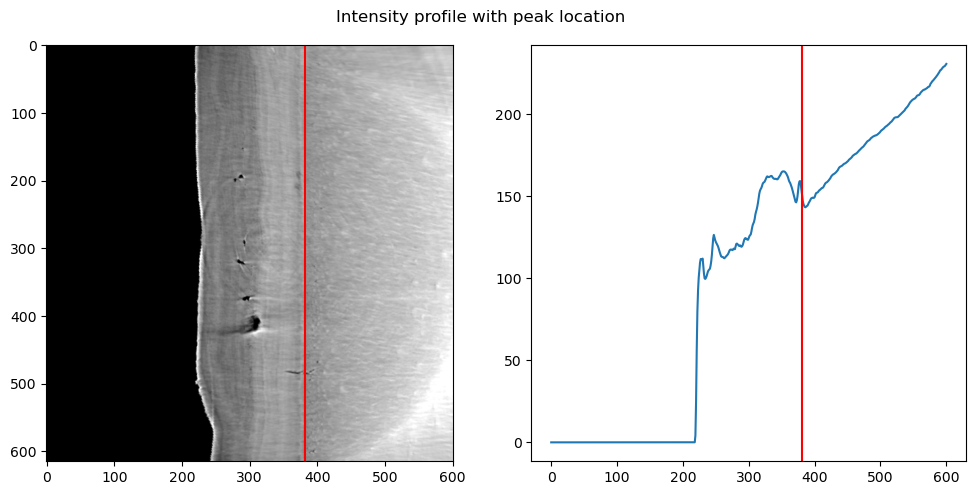

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(straight_image, cmap="gray")
axes[0].axvline(peak_location, color="r")

axes[1].plot(avg_intensity)
axes[1].axvline(peak_location, color="r")

fig.suptitle("Intensity profile with peak location")
fig.tight_layout()